# **Fake News Classification**

Source: 
https://www.kaggle.com/c/fake-news/

### **Problem Statement**
Build a system to identify unreliable news articles.

### **Evaluation Criteria**
1. Accuracy (From Kaggle)
2. Confusion Matrix
3. ROC AUC Curve

### **About Data**

#### **train.csv:** A full training dataset with the following attributes:

**id**: unique id for a news article

**title**: the title of a news article

**author**: author of the news article

**text**: the text of the article; could be incomplete

**label**: a label that marks the article as potentially unreliable

**1**: Unreliable

**0**: Reliable

**Note:** Here, we will be using the data.csv itself to split into train,validation and test sets. 


## **1. Importing Libraries** 

In [187]:
import nltk
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to C:\Users\ROHITH
[nltk_data]     REDDY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [188]:

import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from tqdm import tqdm
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from scipy.sparse import hstack
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import roc_auc_score

## **2. Understanding Data**

In [189]:
#Reading csv file
dataDf=pd.read_csv("data.csv",encoding="utf-8")

In [190]:
dataDf.columns

Index(['id', 'title', 'author', 'text', 'label'], dtype='object')

In [191]:
dataDf.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


* Id column is not necessary for classification task as it has no useful information.
* Features- All the columns- title, author and text are **TEXT** columns.
* Target- 1- Unreliable , 0- Reliable 

In [192]:
len(dataDf)

20800

There are total of 20,800 records.

In [193]:
dataDf['author'].value_counts()[:5]

Pam Key             243
admin               193
Jerome Hudson       166
Charlie Spiering    141
John Hayward        140
Name: author, dtype: int64

This tells us that authors have written multiple articles.

In [194]:
dataDf['author'].value_counts()[-6:-1]

Hy Feiber                                                          1
Chris Stein                                                        1
MTJ                                                                1
New Moon In Scorpio: Making A Calculated Effort – Motivate3.com    1
EndOfTheWorld                                                      1
Name: author, dtype: int64

Minimum articles written by an author is 1

In [195]:
len(dataDf) - len(dataDf['text'].value_counts())

414

There are 414 unique authors in the dataset.

In [196]:
duplicates = dataDf[dataDf.duplicated(['text'])]
print("Text column duplicates: ",len(duplicates))

duplicates = dataDf[dataDf.duplicated(['text','author'])]
print("Text and author column duplicates together: ",len(duplicates))

duplicates= dataDf[dataDf.duplicated(['title','text','author'])]
print("Text, author and title column duplicates together: ",len(duplicates))


Text column duplicates:  413
Text and author column duplicates together:  352
Text, author and title column duplicates together:  109


In [197]:
#Select unique records considering combination of 3 columns 
dataDf_without_duplicates=dataDf.drop_duplicates(subset=['title','text','author'])

In [198]:
print("Duplicates removed: ",len(dataDf)-len(dataDf_without_duplicates))

Duplicates removed:  109


In [199]:
dataDf_without_duplicates=dataDf_without_duplicates.drop(columns="id")
dataDf_without_duplicates=dataDf_without_duplicates.reset_index(drop=True)

In [200]:
dataDf_without_duplicates[:5]

,title,author,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [201]:
len(dataDf_without_duplicates)

20691

Dropping Nan Values if any-

In [202]:
dataDf_without_nan=dataDf_without_duplicates.dropna()

In [203]:
print("Nan records:", len(dataDf_without_duplicates)- len(dataDf_without_nan))

Nan records: 2450


## **3. Text Preprocessing**

In [204]:
# Combining all the above stundents
def text_preprocessing(df,column_name):
    
    preprocessed_text_list = []

    for sentence in df[column_name].values:

        #Lowecase conversion and removing spaces at beginning & end
        preprocessed_sentence= sentence.lower().strip()

        #Remove special characters-Keep only alpha numeric characters and spaces between words
        preprocessed_sentence=re.sub('[^A-Za-z0-9 ]+', '', preprocessed_sentence)


        stop_words = set(stopwords.words('english'))  
        word_tokens = preprocessed_sentence.split()
    
        #Removing stopwords
        filtered_sentence = [w for w in word_tokens if not w in stop_words]

        filtered_sentence=" ".join(filtered_sentence)
        preprocessed_text_list.append(filtered_sentence)

    return preprocessed_text_list

    

In [205]:
#Preprocessed text for a record
preprocessed_text_list= text_preprocessing(dataDf_without_nan,'text')

In [206]:
#Original text for a record
dataDf_without_nan['text'].values[0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [207]:
#Preprocessed text for a record
preprocessed_text_list[0]

'house dem aide didnt even see comeys letter jason chaffetz tweeted darrell lucus october 30 2016 subscribe jason chaffetz stump american fork utah image courtesy michael jolley available creative commonsby license apologies keith olbermann doubt worst person world weekfbi director james comey according house democratic aide looks like also know secondworst person well turns comey sent nowinfamous letter announcing fbi looking emails may related hillary clintons email server ranking democrats relevant committees didnt hear comey found via tweet one republican committee chairmen know comey notified republican chairmen democratic ranking members house intelligence judiciary oversight committees agency reviewing emails recently discovered order see contained classified information long letter went oversight committee chairman jason chaffetz set political world ablaze tweet fbi dir informed fbi learned existence emails appear pertinent investigation case reopened jason chaffetz jasonintheh

In [208]:
#Preprocessing other columns
preprocessed_title_list= text_preprocessing(dataDf_without_nan,'title')
preprocessed_author_list= text_preprocessing(dataDf_without_nan,'author')

In [209]:
dataDf_without_nan['preprocessed_text']=preprocessed_text_list
dataDf_without_nan['preprocessed_author']=preprocessed_author_list
dataDf_without_nan['preprocessed_title']=preprocessed_title_list

C:\Users\ROHITH REDDY\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\ROHITH REDDY\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\ROHITH REDDY\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [210]:
dataDf_without_nan

,title,author,text,label,preprocessed_text,preprocessed_author,preprocessed_title
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide didnt even see comeys letter ja...,darrell lucus,house dem aide didnt even see comeys letter ja...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,ever get feeling life circles roundabout rathe...,daniel j flynn,flynn hillary clinton big woman campus breitbart
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired october 29 2016 tension ...,consortiumnewscom,truth might get fired
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,videos 15 civilians killed single us airstrike...,jessica purkiss,15 civilians killed single us airstrike identi...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six years prison...,howard portnoy,iranian woman jailed fictional unpublished sto...
5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0,trying times jackie mason voice reason weeks e...,daniel nussbaum,jackie mason hollywood would love trump bombed...
7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0,paris france chose idealistic traditional cand...,alissa j rubin,benot hamon wins french socialist partys presi...
9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0,week michael flynn resigned national security ...,megan twohey scott shane,backchannel plan ukraine russia courtesy trump...
10,Obama’s Organizing for Action Partners with So...,Aaron Klein,"Organizing for Action, the activist group that...",0,organizing action activist group morphed barac...,aaron klein,obamas organizing action partners soroslinked ...
11,"BBC Comedy Sketch ""Real Housewives of ISIS"" Ca...",Chris Tomlinson,The BBC produced spoof on the “Real Housewives...,0,bbc produced spoof real housewives tv programm...,chris tomlinson,bbc comedy sketch real housewives isis causes ...


In [211]:
#Preprocessed Dataframe
preprocessed_df=dataDf_without_nan.drop(columns=["author","title","text"])

In [212]:
preprocessed_df

,label,preprocessed_text,preprocessed_author,preprocessed_title
0,1,house dem aide didnt even see comeys letter ja...,darrell lucus,house dem aide didnt even see comeys letter ja...
1,0,ever get feeling life circles roundabout rathe...,daniel j flynn,flynn hillary clinton big woman campus breitbart
2,1,truth might get fired october 29 2016 tension ...,consortiumnewscom,truth might get fired
3,1,videos 15 civilians killed single us airstrike...,jessica purkiss,15 civilians killed single us airstrike identi...
4,1,print iranian woman sentenced six years prison...,howard portnoy,iranian woman jailed fictional unpublished sto...
5,0,trying times jackie mason voice reason weeks e...,daniel nussbaum,jackie mason hollywood would love trump bombed...
7,0,paris france chose idealistic traditional cand...,alissa j rubin,benot hamon wins french socialist partys presi...
9,0,week michael flynn resigned national security ...,megan twohey scott shane,backchannel plan ukraine russia courtesy trump...
10,0,organizing action activist group morphed barac...,aaron klein,obamas organizing action partners soroslinked ...
11,0,bbc produced spoof real housewives tv programm...,chris tomlinson,bbc comedy sketch real housewives isis causes ...


In [213]:
preprocessed_df=preprocessed_df.reset_index(drop=True)

In [214]:
preprocessed_df['label'].value_counts()

0    10361
1     7880
Name: label, dtype: int64

Perform undersampling to avoid RAM issues-

**Note:** The ratios of positive and negative samples are preserved while undersampling.

In [215]:
X=preprocessed_df.drop(columns=["label"])
y=preprocessed_df["label"]

## **4. Train Test Splitting**

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=2)

We have used **stratify=y** to preserve same ratios of positive and negative samples in both training and test sets.

In [217]:
X_train=X_train.reset_index(drop=True)
y=y.reset_index(drop=True)

In [218]:
X_train

,preprocessed_text,preprocessed_author,preprocessed_title
0,vips memos november 13 2016 donald trumps win ...,consortiumnewscom,consortiumnews
1,breaking trump moves file charges clinton oct ...,admin,breaking trump moves file charges clinton
2,san francisco uber years engaged worldwide pro...,mike isaac,uber deceives authorities worldwide new york t...
3,mural painted state property near san diego de...,assemblyman tim donnelly,border wall mural state property depicts ice a...
4,u2 frontman bono condemned idea national borde...,jerome hudson,bono world leaders wall high enough keep islam...
5,yet recovered severe earthquakes recent months...,thomas williams phd,wham italy pummeled 10 earthquakes four hours
6,new york mayor bill de blasio forced share may...,mona salama,ny mayoral candidate bo dietl send ms13 gang g...
7,hard imagine tax code favorable real estate de...,james b stewart,trump gets way real estate get even tax breaks...
8,natasha longo comes recommendations healthy fo...,heather callaghan,one raw egg per day reduces 5th leading cause ...
9,marks important victory inuit protested went h...,alexa erickson,protest muskrat falls mainstream media ignored...


## **5. Feature Engineering**

### **Bag of Words (BoW)**- Using Count Vectorizer to transform text to numerical vectors based on their frequencies. 

In [219]:
# We are considering only the bigrams which appeared in at least 10 documents(rows or projects).
text_vectorizer = CountVectorizer(min_df=10,ngram_range=(2,2), max_features=1000)

X_train_text = text_vectorizer.fit_transform(X_train['preprocessed_text'].values)
X_test_text=text_vectorizer.transform(X_test['preprocessed_text'].values)

print("Shape of matrix after one hot encodig ",X_train_text.shape)

Shape of matrix after one hot encodig  (13680, 1000)


In [220]:
# We are considering only the bigrams which appeared in at least 10 documents(rows or projects).
title_vectorizer = CountVectorizer(min_df=10,ngram_range=(2,2), max_features=200)

X_train_title = title_vectorizer.fit_transform(X_train['preprocessed_title'].values)
X_test_title=title_vectorizer.transform(X_test['preprocessed_title'].values)

print("Shape of matrix after one hot encodig ",X_train_text.shape)

Shape of matrix after one hot encodig  (13680, 1000)


In [221]:
# We are considering only the bigrams which appeared in at least 10 documents(rows or projects).
author_vectorizer = CountVectorizer(min_df=10,ngram_range=(2,2))

X_train_author = author_vectorizer.fit_transform(X_train['preprocessed_author'].values)
X_test_author=author_vectorizer.transform(X_test['preprocessed_author'].values)

print("Shape of matrix after one hot encodig ",X_train_text.shape)

Shape of matrix after one hot encodig  (13680, 1000)


### Combining all the feature columns

In [222]:
X_train_sparse=hstack((sparse.csr_matrix((X_train_text)),X_train_title, X_train_author))
X_test_sparse=hstack((sparse.csr_matrix((X_test_text)),X_test_title, X_test_author))

##  **6.Modeling and Evaluation**

* **Classifier**- Multinomial Naive Bayes
* **Hyperparameter**- alpha
* **Validation Mechanism**- Grid Search

In [223]:
alpha=[0,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.1,0.5,0.7,0.9,1,\
3,5,9,13,15,27,30,50,80,100,200,500,1000]


In [224]:
alpha_dict={'alpha':alpha}

mnb=MultinomialNB(class_prior = [0.5,0.5])

#GridsearchCV with 5 CV's
gs5=GridSearchCV(mnb,param_grid=alpha_dict,scoring='accuracy',return_train_score=True, cv=5)
gs5.fit(X_train_sparse,y_train)

C:\Users\ROHITH REDDY\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\ROHITH REDDY\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\ROHITH REDDY\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\ROHITH REDDY\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\ROHITH REDDY\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5], fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.1, 0.5, 0.7, 0.9, 1, 3, 5, 9, 13, 15, 27, 30, 50, 80, 100, 200, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [225]:
gs5.best_score_

0.9487573099415205

Accuracy- 

In [226]:
gs5.best_params_

{'alpha': 0}

Best Hyper parameter value- 

In [227]:
gs5.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [228]:
train_acc=gs5.cv_results_.get('mean_train_score')
cv_acc=gs5.cv_results_.get('mean_test_score')

In [229]:
from math import log
#Apply log on each alpha for better graphical visualization
def applylog(a):
    if a!=0:
        return log(a,10)
    else:
        return a


#### **Elbow curve- Grid Search Training vs Validation trade-off**

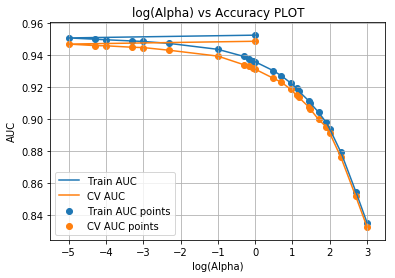

In [230]:
plt.plot(list(map(applylog,alpha)), train_acc, label='Train AUC')
plt.plot(list(map(applylog,alpha)), cv_acc, label='CV AUC')
plt.scatter(list(map(applylog,alpha)), train_acc, label='Train AUC points')
plt.scatter(list(map(applylog,alpha)), cv_acc, label='CV AUC points')
plt.legend()
plt.xlabel("log(Alpha)")
plt.ylabel("AUC")
plt.title("log(Alpha) vs Accuracy PLOT")
plt.grid()
plt.show()

* The hyperameter can also be chosen from the above elbow curve apart from Grid Search.
* Selection criteria- Choose a point in such a way that the difference between train and cv auc should be minimum and cv auc to be maximum, i.e the elbow point in the above graph. 

In [231]:
y_train_pred=gs5.predict(X_train_sparse)
y_test_pred=gs5.predict(X_test_sparse)

In [232]:
#Taking only positive samples
y_train_pos_pred=gs5.predict_log_proba(X_train_sparse)[:,1]
y_test_pos_pred=gs5.predict_log_proba(X_test_sparse)[:,1]

In [233]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pos_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pos_pred)

## **AUC Curve**

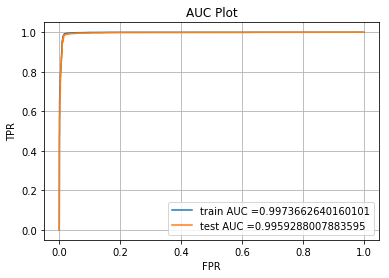

In [234]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC Plot")
plt.grid()
plt.show()

* Both train and test auc are higher.
* Also, there is no significance between them tells us that there is no overfitting or underfitting.

### **Confusion Matrix for Train and Test sets**

Confusion matrix for Training Data
[[7708   62]
 [ 587 5323]]


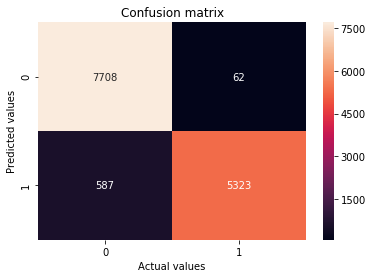

In [235]:
print("Confusion matrix for Training Data")
print(confusion_matrix(y_train,y_train_pred))
hmap=sns.heatmap(confusion_matrix(y_train,y_train_pred),annot=True,fmt='g')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Confusion matrix')
plt.show()

* 0- Reliable, 1- Unreliable
* True positives(TPs) and True Negatives(TNs)- Significantly high tells us that the model classified well in understanding both the classes and there is no bias with respect to classifying a single class.
* Both TPs and TNs are relatively higer than False Positives and False Negatives tells us that the model better understood the text features in classifying the Fake News.     

Confusion matrix for Testing Data
[[2567   24]
 [ 213 1757]]


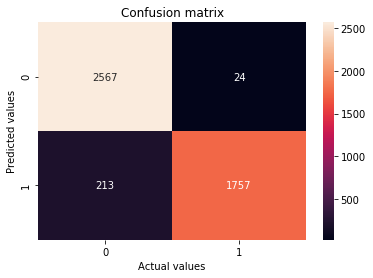

In [236]:
print("Confusion matrix for Testing Data")
print(confusion_matrix(y_test, y_test_pred))
hmap=sns.heatmap(confusion_matrix(y_test, y_test_pred),annot=True,fmt='g')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Confusion matrix')
plt.show()

The above observations holds on the test data as well.

### **7. Conclusion**
* In general, Naive Bayes Classifier(NBC) works well with the text data.
* Hence we have choosen Naive Bayes Classifier for Fake News Classification task.
* We have used Bag Of Words(BoW) for our feature engineering on text data. Further, we can also replace the same by using Term Frequency- Inverse Document Frequency(TFIDF) mechanism for the same.
* With NBC, we have achieved better Accuracy, AUC and Confusion matrix values with the help of better feature engineering and hyperparameter tuning.


### Model Saving and Vectorizers Saving

In [237]:
import pickle

with open('text_vectorizer.pickle', 'wb') as fin:
    pickle.dump(text_vectorizer, fin)

with open('title_vectorizer.pickle', 'wb') as fin:
    pickle.dump(title_vectorizer, fin)

with open('author_vectorizer.pickle', 'wb') as fin:
    pickle.dump(author_vectorizer, fin)

with open('gridsearch_naive_bayes.pickle', 'wb') as fin:
    pickle.dump(gs5, fin)
